<a href="https://colab.research.google.com/github/usmanadedeji97/ISE-571/blob/main/Assignment_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geospatial Data Visualization and Analysis

## Package Installs

In [ ]:
!pip install osmnx geopandas networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.1 MB/s eta 0:00:00


### Dataset:
OpenStreetMap (OSM) road network data for downtown Dammam, Saudi Arabia. The dataset is a directed road graph where nodes represent intersections with latitude/longitude coordinates and edges represent road segments with geometries and lengths in meters.


In [ ]:
import osmnx as ox

center = (26.437220819211202, 50.10368290620161)  # Dammam center (lat, lon)
dist = 2000  # 2 km
G = ox.graph_from_point(center, dist=dist, network_type="drive")
# Add edge lengths (in meters) from geometry
for u, v, k, data in G.edges(keys=True, data=True):
    if 'geometry' in data:
        data['length'] = data['geometry'].length
G

### Q2: Visualizations
Convert graph to GeoDataFrames

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

nodes.head(), edges.head()

(                   y          x  street_count highway  \
 osmid                                                   
 287566518  26.423206  50.085333             3     NaN   
 287566574  26.424559  50.085076             3     NaN   
 287566577  26.424614  50.085327             3     NaN   
 287566595  26.424278  50.085319             3     NaN   
 287566753  26.426227  50.085519             4     NaN   
 
                             geometry  
 osmid                                 
 287566518  POINT (50.08533 26.42321)  
 287566574  POINT (50.08508 26.42456)  
 287566577  POINT (50.08533 26.42461)  
 287566595  POINT (50.08532 26.42428)  
 287566753  POINT (50.08552 26.42623)  ,
                               osmid   highway maxspeed         name  oneway  \
 u         v          key                                                      
 287566518 2379344316 0     26257108   primary       80  28th Street    True   
           7403604230 0     47029544  tertiary      NaN          NaN   

### Road network overview

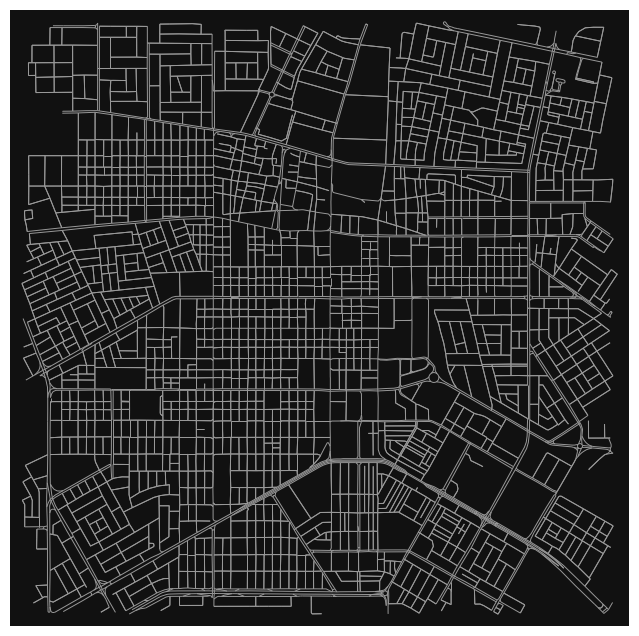

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.plot_graph(G, node_size=0, edge_linewidth=0.7)


### Edge length heatmap-like

<Figure size 1400x1200 with 0 Axes>

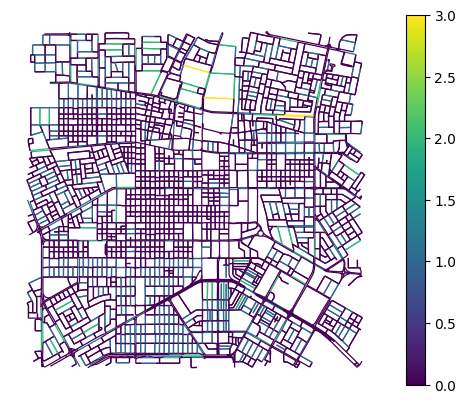

In [ ]:
edges2 = edges.copy()
edges2["len_bin_m"] = (edges2["length"] // 100).clip(0, 30)  # 0..3000+ meters

plt.figure(figsize=(14, 12))
ax = edges2.plot(column="len_bin_m", legend=True, linewidth=0.9)
ax.set_axis_off()
plt.show()


### Node density hexbin

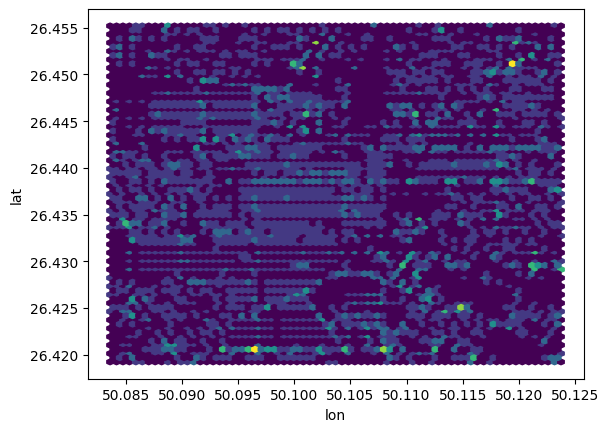

In [ ]:
xs = nodes.geometry.x.to_numpy()
ys = nodes.geometry.y.to_numpy()

plt.hexbin(xs, ys, gridsize=70)
plt.xlabel("lon")
plt.ylabel("lat")
plt.show()


### Visualizing road type map

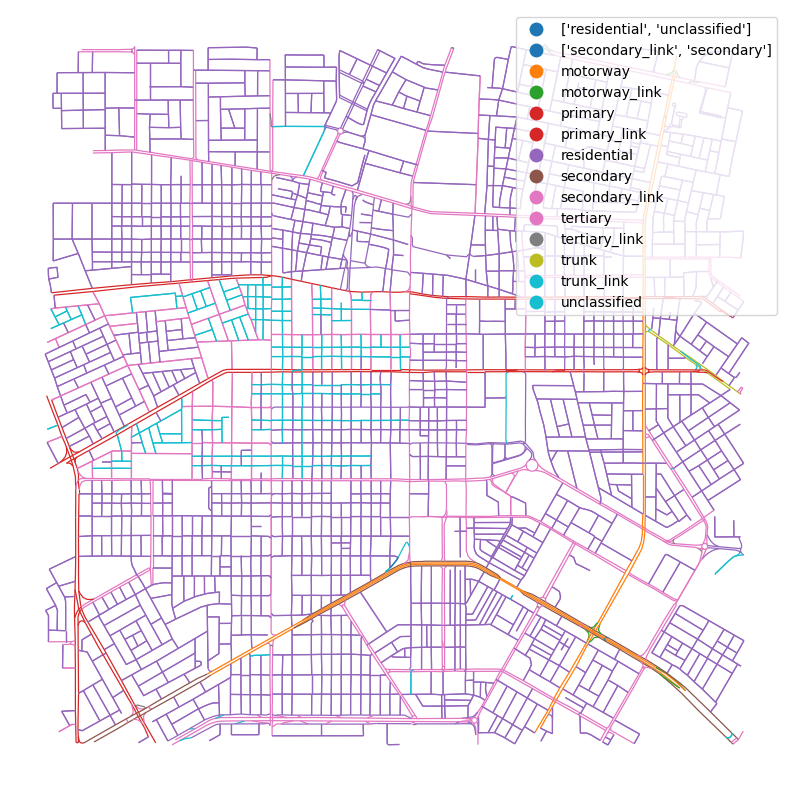

In [ ]:
import matplotlib.pyplot as plt

edges3 = edges.copy()
edges3["highway_str"] = edges3["highway"].astype(str)

fig, ax = plt.subplots(figsize=(20, 10))  # increase size here
edges3.plot(column="highway_str", legend=True, linewidth=0.9, ax=ax)

ax.set_axis_off()
plt.show()


### Insights

The road network shows a clear hierarchy: major arterial roads (motorways, primary, trunk) form the main mobility corridors, while residential streets dominate in number and create a dense grid structure.

Road density is highest in the urban core, indicating smaller block sizes, higher intersection frequency, and more intensive land use.

Peripheral areas within the selected boundary have lower road density and longer road segments, suggesting larger land parcels and less compact development.

Short road segments are concentrated in central neighborhoods, while longer segments appear mainly along major corridors designed for faster traffic movement.


# Q3

### Picking two points on a map.

Khobar Mall (26.31766394839814, 50.21999468854554),
Khobar Sea Port (26.2951969492867, 50.22634615943445)

In [3]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 7.8 MB/s eta 0:00:00


In [4]:
import osmnx as ox
import folium

# POIs (lat, lon)
poi1_name, poi1 = "Khobar Mall", (26.31766394839814, 50.21999468854554)
poi2_name, poi2 = "Khobar Sea Port", (26.2951969492867, 50.22634615943445)

# Center the map between the two points
center_lat = (poi1[0] + poi2[0]) / 2
center_lon = (poi1[1] + poi2[1]) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

folium.Marker(
    location=[poi1[0], poi1[1]],
    popup=poi1_name,
    tooltip=poi1_name,
    icon=folium.Icon(icon="info-sign")
).add_to(m)

folium.Marker(
    location=[poi2[0], poi2[1]],
    popup=poi2_name,
    tooltip=poi2_name,
    icon=folium.Icon(color="green", icon="info-sign")
).add_to(m)
m


# Q4

### Finding the shortest path between Khobar Mall (26.31766394839814, 50.21999468854554), Khobar Sea Port (26.2951969492867, 50.22634615943445)

In [5]:
# !pip install osmnx
!pip install optalgotools

import osmnx
from optalgotools.structures import Node
from optalgotools.routing import cost, draw_route
from optalgotools.algorithms.graph_search import BFS, DFS, Dijkstra
import pandas as pd
import time, math, random, sys

pd.options.compute.use_numexpr = False


### Defining  POIs

In [6]:
# Dammam downtown POIs (lat, lon)

source_point = (26.31766394839814, 50.21999468854554)       # Khobar Mall
destination_point = (26.2951969492867, 50.22634615943445)  # Khobar Sea Port

# midpoint reference
reference_point = (
    (source_point[0] + destination_point[0]) / 2,
    (source_point[1] + destination_point[1]) / 2
)

# graph around midpoint (increase dist as needed)
G = osmnx.graph_from_point(reference_point, dist=2500, simplify=True, network_type="drive")
# Add edge lengths (in meters). some osmnx versions removed add_edge_lengths,
# so compute lengths from geometry when available or haversine between nodes.
import math
def _haversine(lat1, lon1, lat2, lon2):
    R = 6371000.0
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1); dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1 - a))
for u, v, k, data in G.edges(keys=True, data=True):
    if 'length' in data:
        continue
    if 'geometry' in data and data['geometry'] is not None:
        # geometry.length yields meters for projected geometries; for lat/lon it's in degrees
        try:
            data['length'] = data['geometry'].length
            continue
        except Exception:
            pass
    # fallback: compute haversine distance between node coordinates
    u_n = G.nodes[u]
    v_n = G.nodes[v]
    data['length'] = _haversine(u_n.get('y', u_n.get('lat')), u_n.get('x', u_n.get('lon')), v_n.get('y', v_n.get('lat')), v_n.get('x', v_n.get('lon')))

# nearest nodes
origin_id = osmnx.distance.nearest_nodes(G, source_point[1], source_point[0])
destination_id = osmnx.distance.nearest_nodes(G, destination_point[1], destination_point[0])

# Node objects (demo style)
origin = Node(graph=G, osmid=origin_id)
destination = Node(graph=G, osmid=destination_id)

origin_id, destination_id


(2380385934, 5373117466)

BFS

In [7]:
solution_bfs = BFS(origin, destination)
route_bfs = solution_bfs.result

print(f"Cost: {cost(G, route_bfs)} m")
print(f"Process time: {solution_bfs.time} s")
print(f"Space required: {solution_bfs.space} bytes")
print(f"Explored nodes: {solution_bfs.explored}")

draw_route(G, route_bfs)


Cost: 5390.7212 m
Process time: 0.02106870699999952 s
Space required: 1816 bytes
Explored nodes: 974


### DFS

In [8]:
solution_dfs = DFS(origin, destination)
route_dfs = solution_dfs.result

print(f"Cost: {cost(G, route_dfs)} m")
print(f"Process time: {solution_dfs.time} s")
print(f"Space required: {solution_dfs.space} bytes")
print(f"Explored nodes: {solution_dfs.explored}")

draw_route(G, route_dfs)


Cost: 20812.0432 m
Process time: 0.01869469399999879 s
Space required: 1816 bytes
Explored nodes: 633


### Dijkstra

In [9]:
unrelaxed_nodes = [Node(G, osmid) for osmid in G.nodes()]

solution_dij = Dijkstra(origin, destination, unrelaxed_nodes)
route_dij = solution_dij.result

print(f"Cost: {cost(G, route_dij)} m")
print(f"Process time: {solution_dij.time} s")
print(f"Space required: {solution_dij.space} bytes")
print(f"Explored nodes: {solution_dij.explored}")

draw_route(G, route_dij)


Cost: 5390.7212 m
Process time: 0.8714154159999996 s
Space required: 18232 bytes
Explored nodes: 1959


### Simulated Annealing

In [10]:
def dijkstra_path_ids(G, a, b):
    return osmnx.shortest_path(G, a, b, weight="length")

class SimpleSolution:
    def __init__(self, result, time_s, space_bytes, explored):
        self.result = result
        self.time = time_s
        self.space = space_bytes
        self.explored = explored

def simulated_annealing_route(G, start_id, goal_id, init_route, iters=400, T0=300.0, alpha=0.98, seed=2):
    random.seed(seed)

    t0 = time.perf_counter()

    best = init_route[:]
    best_cost = cost(G, best)

    cur = init_route[:]
    cur_cost = best_cost

    explored = 0
    T = T0

    for _ in range(iters):
        explored += 1

        if len(cur) < 6:
            break

        i = random.randint(2, len(cur) - 3)
        pivot = cur[i]

        try:
            r1 = dijkstra_path_ids(G, start_id, pivot)
            r2 = dijkstra_path_ids(G, pivot, goal_id)
            cand = r1[:-1] + r2
        except Exception:
            T *= alpha
            continue

        cand_cost = cost(G, cand)
        delta = cand_cost - cur_cost

        if delta < 0 or random.random() < math.exp(-delta / max(T, 1e-9)):
            cur, cur_cost = cand, cand_cost
            if cur_cost < best_cost:
                best, best_cost = cur[:], cur_cost

        T *= alpha

    t1 = time.perf_counter()
    space_bytes = sys.getsizeof(best)

    return SimpleSolution(best, t1 - t0, space_bytes, explored)

solution_sa = simulated_annealing_route(G, origin_id, destination_id, route_dij, iters=500, T0=400.0, alpha=0.985, seed=2)
route_sa = solution_sa.result

print(f"Cost: {cost(G, route_sa)} m")
print(f"Process time: {solution_sa.time} s")
print(f"Space required: {solution_sa.space} bytes")
print(f"Explored nodes: {solution_sa.explored}")

draw_route(G, route_sa)


Cost: 5390.7212 m
Process time: 9.83307985800002 s
Space required: 288 bytes
Explored nodes: 500


## Performance Comparison of the four Algorithms

In [11]:
results = pd.DataFrame([
    {"Algorithm": "BFS", "Time (s)": solution_bfs.time, "Cost (m)": cost(G, route_bfs)},
    {"Algorithm": "DFS", "Time (s)": solution_dfs.time, "Cost (m)": cost(G, route_dfs)},
    {"Algorithm": "Dijkstra", "Time (s)": solution_dij.time, "Cost (m)": cost(G, route_dij)},
    {"Algorithm": "SA", "Time (s)": solution_sa.time, "Cost (m)": cost(G, route_sa)},
]).sort_values("Cost (m)")

results


,Algorithm,Time (s),Cost (m)
0,BFS,0.021069,5390.7212
2,Dijkstra,0.871415,5390.7212
3,SA,9.833080,5390.7212
1,DFS,0.018695,20812.0432
